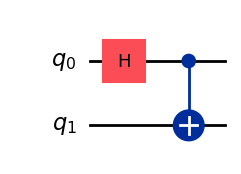

In [1]:
from qiskit import QuantumCircuit

# 2 qubits = 4 hidden states
initial_state = QuantumCircuit(2, name='Initial_State')
initial_state.h(0)
initial_state.cx(0,1)
initial_state.draw('mpl')

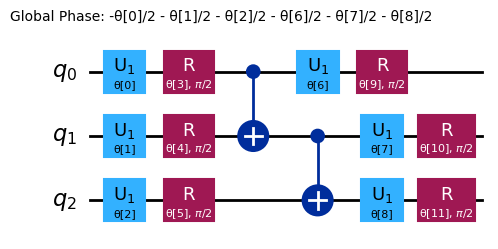

In [2]:
from qiskit.circuit.library import real_amplitudes, efficient_su2

#ansatz = real_amplitudes(4, reps=1, entanglement='pairwise', )
ansatz = efficient_su2(3, reps=1, entanglement='pairwise', su2_gates=['rz','ry'])
ansatz.decompose(reps=1).draw('mpl')

In [3]:
import numpy as np

# Generating and starting parameters
num_parameters = ansatz.num_parameters

theta = [np.random.uniform(2*np.pi,  6* np.pi) for _ in range(num_parameters)]

In [4]:
from HMM.utils.qhmm_utils import result_getter
from qiskit.quantum_info.operators.operator import Operator
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit

from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix

# This class `aer_simulator_result_getter` uses the AerSimulator to generate sequences and calculate
# log-likelihood for quantum circuits.
class latent_state_result_getter(result_getter):
    def __init__(self,
              ):       
        self.simulator = AerSimulator()
        self.save_state = True


    def generate_sequence(self, 
                          circuit : QuantumCircuit):
        """
        This function generates a sequence of integers based on the measurement outcomes of a quantum
        circuit generated by a QHMM, executed on the AerSimulator.
        
        :param circuit: The `generate_sequence` method takes a QuantumCircuit object named `circuit` as
        input.
        :type circuit: QuantumCircuit
        :return: The function `generate_sequence` returns a list of integers representing the
        measurement outcomes of a quantum circuit run on a quantum simulator.
        """
        super().generate_sequence()
        transpiled = transpile(circuits=circuit, backend=self.simulator)
        result = self.simulator.run(transpiled, shots=1).result()
        sequence = [int(binary, 2) for binary in next(iter(result.get_counts())).split()]
        return sequence
    
    def log_likelihood(self, 
                       circuit : QuantumCircuit, 
                       sequence : list[int]):
        """
        This function calculates the log likelihood of observing a given sequence of outcomes from a
        quantum circuit simulation. This method is called by the QHMM.log_likelihood() method.
        
        :param circuit: The `circuit` parameter in the `log_likelihood` function is a QuantumCircuit
        created by the QHMM log_likelihood method
        :type circuit: QuantumCircuit
        :param sequence: The `sequence` parameter in the `log_likelihood` function is a list of integers
        representing the observed outcomes at each step of the quantum circuit execution. This method determines
        the likelihood of the sequence being observed by the model.
        :type sequence: list[int]
        :return: The `log_likelihood` function returns the log likelihood value calculated based on the
        given quantum circuit and observation sequence. If the likelihood value is 0, it returns
        negative infinity, otherwise, it returns the natural logarithm of the likelihood value.
        """

        latent_states = []
        mid_seq_probs = []

        # retrieve the bound ansatz from the circuit
        bound_ansatz = circuit.data[2].operation #self.ansatz.assign_parameters(params)
        initial_state = circuit.data[0].operation

        likelihood = 1
        observed_qargs = [i for i in range(circuit.qregs[0].size, circuit.num_qubits)]
        hidden_qargs = [i for i in range(circuit.qregs[0].size)]
        dm = DensityMatrix(data=QuantumCircuit(circuit.qubits))
        
        dm = dm.evolve(initial_state, qargs=hidden_qargs)

        for step, sample in enumerate(sequence):
            # save the statevector from each time step
            dm = dm.evolve(bound_ansatz)
            probs = dm.probabilities(observed_qargs)
            likelihood *= probs[sample]
            mid_seq_probs.append(likelihood)

            if likelihood == 0:
                break
            proj = np.zeros(len(probs), dtype=complex)
            proj[sample] = 1 / np.sqrt(probs[sample])
            dm = dm.evolve(Operator(np.diag(proj), input_dims=dm.dims(observed_qargs), output_dims=dm.dims(observed_qargs)), qargs=observed_qargs)
            dm = dm.reset(observed_qargs)
            latent_states.append(dm)
        

        return latent_states, mid_seq_probs

In [ ]:
from HMM.utils.qhmm_utils import result_getter
from qiskit.quantum_info.operators.operator import Operator
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import transpile, QuantumCircuit

from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix

# This class `aer_simulator_result_getter` uses the AerSimulator to generate sequences and calculate
# log-likelihood for quantum circuits.
class causal_break_result_getter(result_getter):
    def __init__(self,
                 density_matrix,
                 cutoff_step,
              ):
        self.cutoff_step = cutoff_step       
        self.density_matrix = density_matrix
        self.simulator = AerSimulator()
        self.save_state = True


    def generate_sequence(self, 
                          circuit : QuantumCircuit):
        """
        This function generates a sequence of integers based on the measurement outcomes of a quantum
        circuit generated by a QHMM, executed on the AerSimulator.
        
        :param circuit: The `generate_sequence` method takes a QuantumCircuit object named `circuit` as
        input.
        :type circuit: QuantumCircuit
        :return: The function `generate_sequence` returns a list of integers representing the
        measurement outcomes of a quantum circuit run on a quantum simulator.
        """
        super().generate_sequence()
        transpiled = transpile(circuits=circuit, backend=self.simulator)
        result = self.simulator.run(transpiled, shots=1).result()
        sequence = [int(binary, 2) for binary in next(iter(result.get_counts())).split()]
        return sequence
    
    def log_likelihood(self, 
                       circuit : QuantumCircuit, 
                       sequence : list[int]):
        """
        This function calculates the log likelihood of observing a given sequence of outcomes from a
        quantum circuit simulation. This method is called by the QHMM.log_likelihood() method.
        
        :param circuit: The `circuit` parameter in the `log_likelihood` function is a QuantumCircuit
        created by the QHMM log_likelihood method
        :type circuit: QuantumCircuit
        :param sequence: The `sequence` parameter in the `log_likelihood` function is a list of integers
        representing the observed outcomes at each step of the quantum circuit execution. This method determines
        the likelihood of the sequence being observed by the model.
        :type sequence: list[int]
        :return: The `log_likelihood` function returns the log likelihood value calculated based on the
        given quantum circuit and observation sequence. If the likelihood value is 0, it returns
        negative infinity, otherwise, it returns the natural logarithm of the likelihood value.
        """

        latent_states = []
        mid_seq_probs = []

        # retrieve the bound ansatz from the circuit
        bound_ansatz = circuit.data[2].operation #self.ansatz.assign_parameters(params)
        initial_state = circuit.data[0].operation

        likelihood = 1
        observed_qargs = [i for i in range(circuit.qregs[0].size, circuit.num_qubits)]
        hidden_qargs = [i for i in range(circuit.qregs[0].size)]
        dm = DensityMatrix(data=QuantumCircuit(circuit.qubits))
        
        dm = dm.evolve(initial_state, qargs=hidden_qargs)

        for step, sample in enumerate(sequence):
            if step < self.cutoff_step:
                # save the statevector from each time step
                dm = dm.evolve(bound_ansatz)
                probs = dm.probabilities(observed_qargs)
                fake_sample = np.random.choice([i for i in range(len(probs))], p=probs)
                proj = np.zeros(len(probs), dtype=complex)
                proj[fake_sample] = 1 / np.sqrt(probs[fake_sample])
                dm = dm.evolve(Operator(np.diag(proj), input_dims=dm.dims(observed_qargs), output_dims=dm.dims(observed_qargs)), qargs=observed_qargs)
                dm = dm.reset(observed_qargs)

            else:
                if step == self.cutoff_step:
                    dm = self.density_matrix
                    
                 # save the statevector from each time step
                dm = dm.evolve(bound_ansatz)
                probs = dm.probabilities(observed_qargs)
                likelihood *= probs[sample]
                mid_seq_probs.append(likelihood)

                if likelihood == 0:
                    break
                proj = np.zeros(len(probs), dtype=complex)
                proj[sample] = 1 / np.sqrt(probs[sample])
                dm = dm.evolve(Operator(np.diag(proj), input_dims=dm.dims(observed_qargs), output_dims=dm.dims(observed_qargs)), qargs=observed_qargs)
                dm = dm.reset(observed_qargs)
                latent_states.append(dm)
        
        return latent_states, mid_seq_probs

In [43]:
from HMM import QHMM
import itertools

ls_result_getter = latent_state_result_getter()

no_break_model = QHMM(result_getter=ls_result_getter,
                                initial_state=initial_state,
                                ansatz=ansatz,
                                theta=theta)

In [44]:
sequences = [list(seq) for seq in itertools.product([0, 1], repeat=5)]
seq_dict = {}
cutoff_step = 2

for seq in sequences:
    prefix_key = ''.join(str(step) for step in seq[:cutoff_step])
    seq_key = ''.join(str(step) for step in seq[cutoff_step:])

    if not prefix_key in seq_dict.keys():
        seq_dict[prefix_key] = {}

    ls_list, mid_seq_probs = no_break_model.log_likelihood(sequence=seq)
    
    break_model = QHMM(result_getter=causal_break_result_getter(density_matrix=ls_list[cutoff_step-1], cutoff_step=cutoff_step),
                     initial_state=initial_state,
                     ansatz=ansatz,
                     theta=theta)
    _, probability_distribution = break_model.log_likelihood(sequence=seq)

    seq_dict[prefix_key][seq_key] = {
                     'with_prior_meas' : mid_seq_probs,
                     'only_latent_state' : probability_distribution,
                        }

In [45]:
seq_start = list(seq_dict.keys())[1]
print(seq_start)

with_prior_meas = {}
only_latent_state = {}

prefix_prob = None

for seq_end, probs in seq_dict[seq_start].items():
    if prefix_prob == None:
        prefix_prob = probs['with_prior_meas'][len(seq_start)-1]
    with_prior_meas[seq_end] = probs['with_prior_meas'][-1] / prefix_prob
    only_latent_state[seq_end] = probs['only_latent_state'][-1]

01


In [37]:
from qiskit.visualization import plot_histogram

In [51]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plot_histogram([with_prior_meas, only_latent_state], 
               #legend=['with prior measurements', 'without prior measurements'],
               bar_labels=False,
               filename='causal_break_test.png',
               )